# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import glob
import warnings
import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

## 0.2 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
seed = 42
np.random.seed()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\fabio\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.3 Helper Functions

## 0.4 Load Data

In [21]:
for file in glob.glob("01-Data\*.csv"):
    print(file)

01-Data\olist_customers_dataset.csv
01-Data\olist_geolocation_dataset.csv
01-Data\olist_orders_dataset.csv
01-Data\olist_order_items_dataset.csv
01-Data\olist_order_payments_dataset.csv
01-Data\olist_order_reviews_dataset.csv
01-Data\olist_products_dataset.csv
01-Data\olist_sellers_dataset.csv
01-Data\product_category_name_translation.csv


In [34]:
df_raw = pd.read_csv('01-Data/olist_orders_dataset.csv', \
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
                                  'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [35]:
df_raw.sample(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
15105,9f7f0cc34b8ad3893948112ddffed4f8,4384adc463626cb85f6d66d6fd94b5ff,delivered,2018-01-07 15:40:11,2018-01-07 15:51:22,2018-01-09 15:57:31,2018-01-17 23:17:58,2018-02-06
21054,0420da8d50a3784011290a782f25a8a8,0949b5cf9adad08c1421aa3f1778e4a3,delivered,2018-08-09 16:42:43,2018-08-09 17:35:18,2018-08-13 12:48:00,2018-08-16 19:45:47,2018-08-21


# 1.0 DATA DESCRIPTION

In [36]:
df01 = df_raw.copy()

## 1.1 Columns

In [37]:
df01.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

## 1.2 Data Dimensions

In [38]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 99441
Number of Columns: 8


## 1.3 Data Types

In [39]:
df01.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

## 1.4 Data Missing

In [40]:
df01.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# 2.0 FEATURE ENGINEERING

In [42]:
df02 = df01.copy()

In [43]:
df02['order_purchase_year_week'] = df02['order_purchase_timestamp'].dt.strftime('%Y-%W')

In [44]:
df02.sample().T

,82400
order_id,73c2f6a3fe158985da4f15118a77783a
customer_id,d9256d7e870dacf770ddfd2d6ec2b8df
order_status,delivered
order_purchase_timestamp,2018-05-26 19:19:41
order_approved_at,2018-05-26 19:38:18
order_delivered_carrier_date,2018-05-29 16:08:00
order_delivered_customer_date,2018-06-07 18:46:35
order_estimated_delivery_date,2018-07-11 00:00:00
order_purchase_year_week,2018-21


# DATA SELECTION

In [46]:
df03 = df02.copy()

In [47]:
df03 = df03[df03['order_status'] == 'canceled'][['order_id', 'order_purchase_year_week']]
df03.head()

,order_id,order_purchase_year_week
397,1b9ecfe83cdc259250e1a8aca174f0ad,2018-31
613,714fb133a6730ab81fa1d3c1b2007291,2018-04
1058,3a129877493c8189c59c60eb71d97c29,2018-04
1130,00b1cb0320190ca0daa2c88b35206009,2018-35
1801,ed3efbd3a87bea76c2812c66a0b32219,2018-38


# 4.0. Data Preparation

In [52]:
df04 = df03.copy()

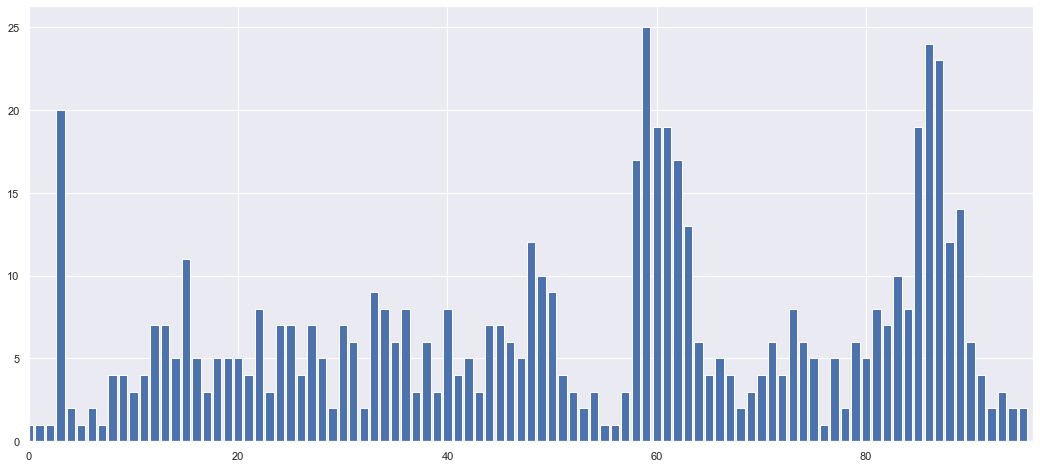

In [53]:
df04 = df04.groupby('order_purchase_year_week').count().reset_index()
df04 = df04.sort_values('order_purchase_year_week')

count_data = np.array(df04['order_id'])
n_count_data = len(count_data)

plt.figure(figsize=(18,8))
plt.bar(np.arange(n_count_data),count_data)
plt.xlim([0, n_count_data ]);

# 5.0. Bayesian Inference

In [55]:
import pymc3 as pm
with pm.Model() as model:
    # Prior
    alpha = 1.0 / count_data.mean()
    lambda_01 = pm.Exponential('lambda_01', alpha)
    lambda_02 = pm.Exponential('lambda_02', alpha) 

    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data-1)


    # Posterior
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_01, lambda_02)
    obs = pm.Poisson('obs', lambda_, observed=count_data)

    # Likelihood
    trace = pm.sample(draws=10000, tune=5000, step=pm.Metropolis())

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_02]
>Metropolis: [lambda_01]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 515 seconds.
The number of effective samples is smaller than 25% for some parameters.


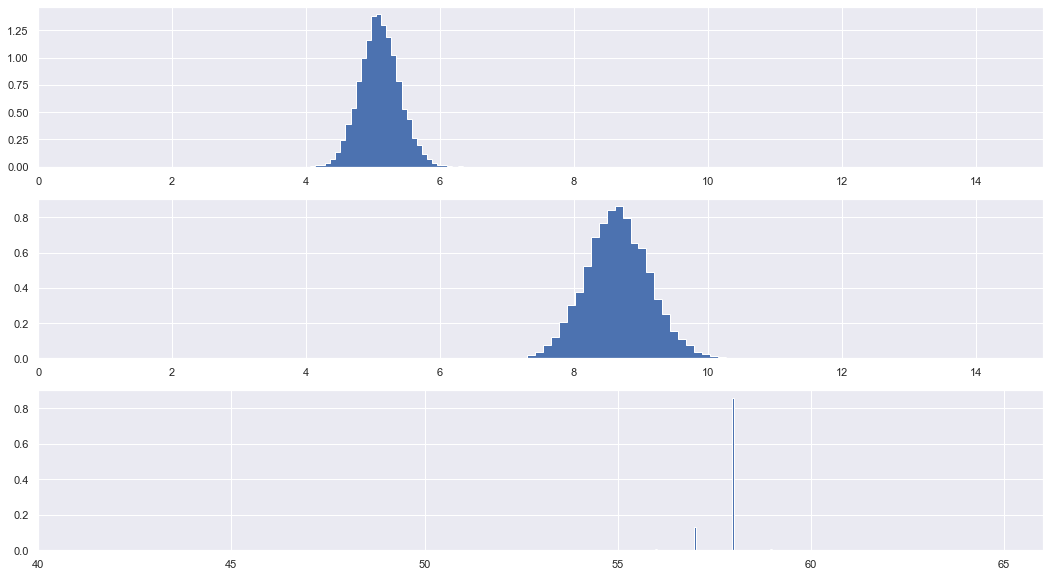

In [56]:
# posterior
plt.figure(figsize=(18, 10))

plt.subplot(3, 1, 1)
plt.hist(trace['lambda_01'], histtype='stepfilled', bins=30, density=True );
plt.xlim([0, 15 ]);

plt.subplot(3, 1, 2)
plt.hist(trace['lambda_02'], histtype='stepfilled', bins=30, density=True);
plt.xlim([0, 15 ]);

plt.subplot(3, 1, 3)
w = 1.0 / trace['tau'].shape[0] * np.ones_like(trace['tau'])
plt.hist(trace['tau'], bins=n_count_data, weights=w, rwidth=2.);
plt.xlim([40, n_count_data-30 ]);

In [57]:
trace['lambda_01'].mean()

5.09598429635927

In [60]:
trace['lambda_02'].mean()

8.649799526481665

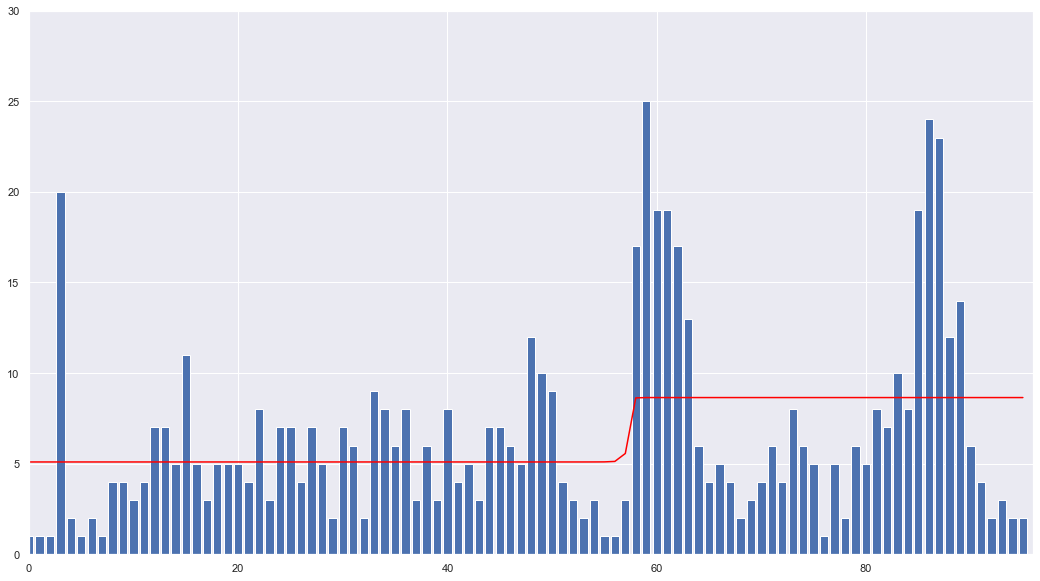

In [59]:
plt.figure(figsize=(18,10))
# Behaviour plot
canceled_by_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < trace['tau']
    canceled_by_day[day] = (trace['lambda_01'][ix].sum() + trace['lambda_02'][~ix].sum()) / trace['tau'].shape[0]
    
# plots 
plt.plot(range(n_count_data), canceled_by_day, color='red')
plt.ylim([0, 30])

plt.bar(np.arange( n_count_data ), count_data)
plt.xlim([0, n_count_data ]);